# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
# plt.style.use('fivethirtyeight')
import pandas as pd

from scipy import stats
import statsmodels.api as sm
from sklearn import preprocessing
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 8
matplotlib.rcParams['ytick.labelsize'] = 8
matplotlib.rcParams['text.color'] = 'k'

import geopandas as gpd



In [2]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
chicago_df = df.query("City == 'Chicago'")
chicago_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,84640,60640,Chicago,IL,Chicago,Cook,8,216500.0,216700.0,216900.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,84646,60647,Chicago,IL,Chicago,Cook,17,122700.0,122800.0,122800.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,84620,60618,Chicago,IL,Chicago,Cook,20,142600.0,143100.0,143400.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [4]:
chosen_zips = [60607, 60661, 60612, 60622, 60642, 60647, 60614, 60625, 60618, 60657, 60608, 60616]

# Step 2: Data Preprocessing

In [5]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [6]:
# getting it down to just the relevant information for time series predictions
to_drop = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
chicago_df = chicago_df.drop(to_drop, axis=1)
chicago_df.head()

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,60614,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
7,60640,216500.0,216700.0,216900.0,217000.0,217100.0,217200.0,217500.0,217900.0,218600.0,...,798000,787100,776100,774900,777900,777900,778500,780500,782800,782800
16,60647,122700.0,122800.0,122800.0,122700.0,122400.0,122000.0,121500.0,120900.0,120500.0,...,459600,461400,464300,466500,467900,470600,474500,475100,472600,470200
19,60618,142600.0,143100.0,143400.0,143300.0,142900.0,142200.0,141300.0,140100.0,139000.0,...,462700,461200,459900,459200,458700,457900,457400,459000,462500,464300


In [7]:
get_datetimes(chicago_df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [9]:
# writing new CSVs with each Chicago zipcode separately

chi_dict = {}
for i, g in chicago_df.groupby('RegionName'):
    
    if i in chosen_zips:
        g.to_csv('{}.csv'.format(i), header=True, index_label=False)
        
        chi_dict[i] = pd.read_csv('{}.csv'.format(i))
    else:
        continue

In [10]:
chosen_zips & chi_dict.keys()

{60607, 60608, 60612, 60614, 60616, 60618, 60622, 60625, 60642, 60647, 60657}

In [11]:
# helper function to reshape into long format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [12]:
# reshaping dataframes to long format
for zipcode in chi_dict.keys():
    chi_dict[zipcode] = melt_data(chi_dict[zipcode])

In [13]:
# removing outliers with a threshold of 1.75, as other measures were less effective
for zipcode in chi_dict.keys():
    chi_dict[zipcode] = chi_dict[zipcode][(np.abs(stats.zscore(chi_dict[zipcode])) < 1.75).all(axis=1)]

237
257
248
237
242
239
232
237
230
236
235


# Step 3: EDA and Visualization

In [14]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [15]:
for zipcode in chi_dict.keys():
    zip_df = pd.concat(chi_dict, axis = 1)

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


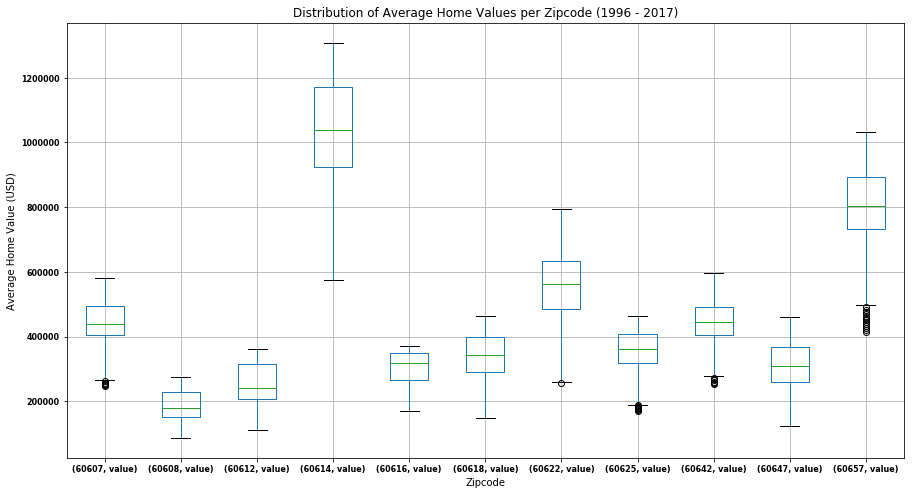

In [16]:
zip_df.boxplot(figsize=(15,8))
plt.title("Distribution of Average Home Values per Zipcode (1996 - 2017)")
plt.xlabel("Zipcode")
plt.ylabel("Average Home Value (USD)")
plt.plot();

In [17]:
# Removing zips out of stakeholders price range
for zipcode in [60607,60614,60622,60642,60657]:
    chi_dict.pop(zipcode)

/Users/Allie/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


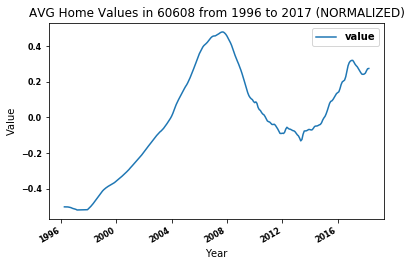

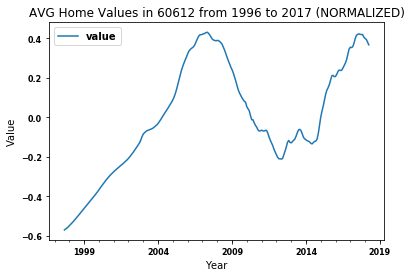

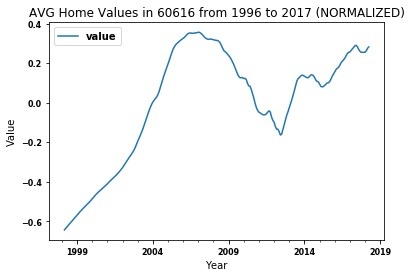

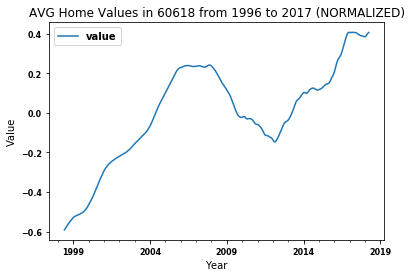

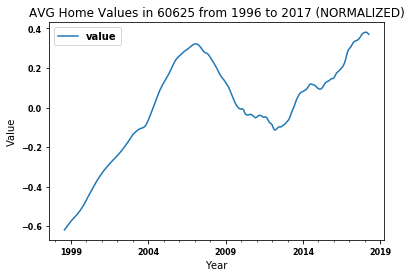

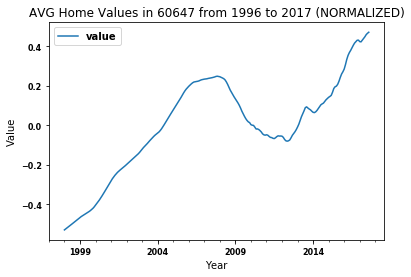

In [18]:
normalized_chi = {}
for zipcode in chi_dict.keys():
    normalized_chi[zipcode] = (chi_dict[zipcode] - chi_dict[zipcode].mean()) / (chi_dict[zipcode].max() - chi_dict[zipcode].min())
    

    normalized_chi[zipcode].plot(figsize=(6,4))
        
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.title(f"AVG Home Values in {zipcode} from 1996 to 2017 (NORMALIZED)")
    plt.show();

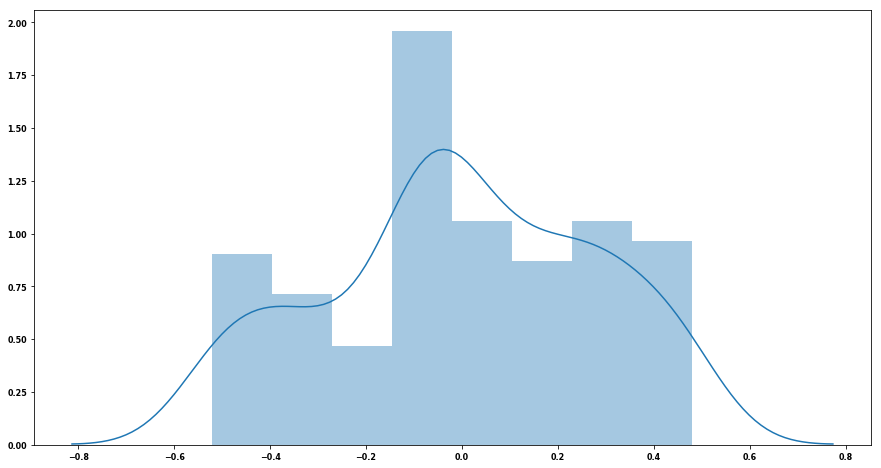

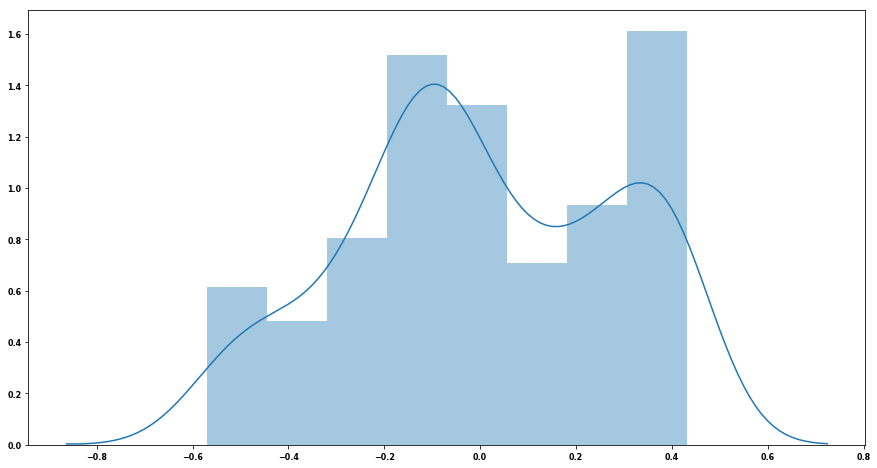

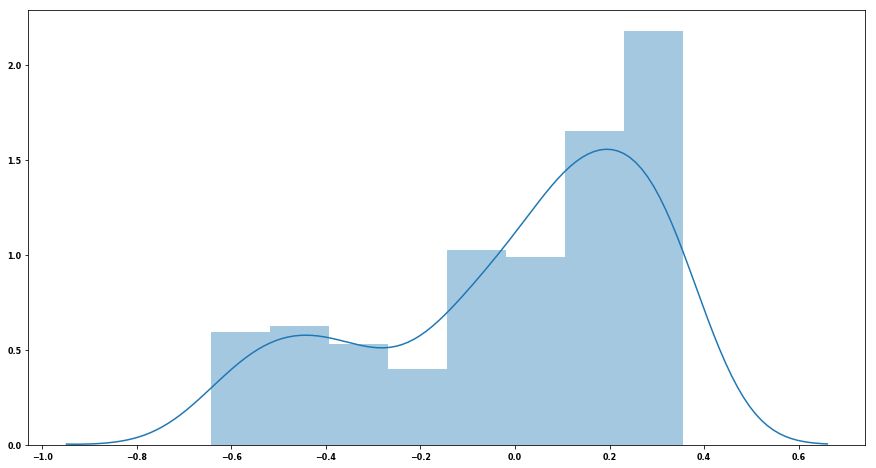

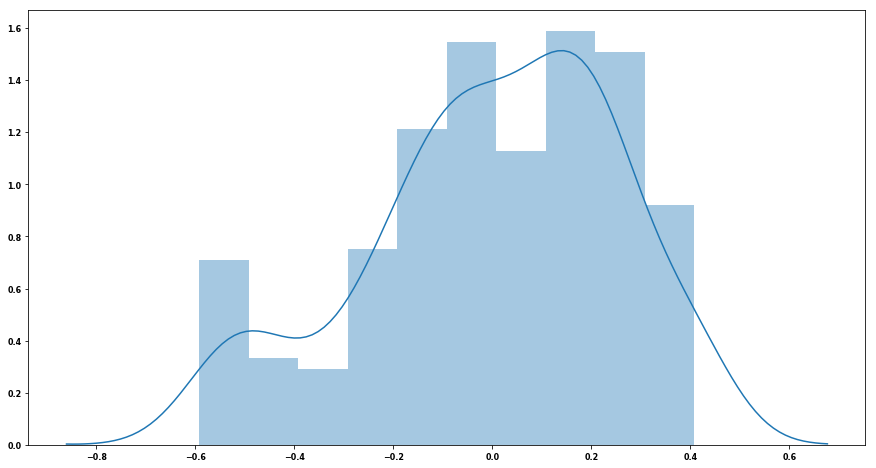

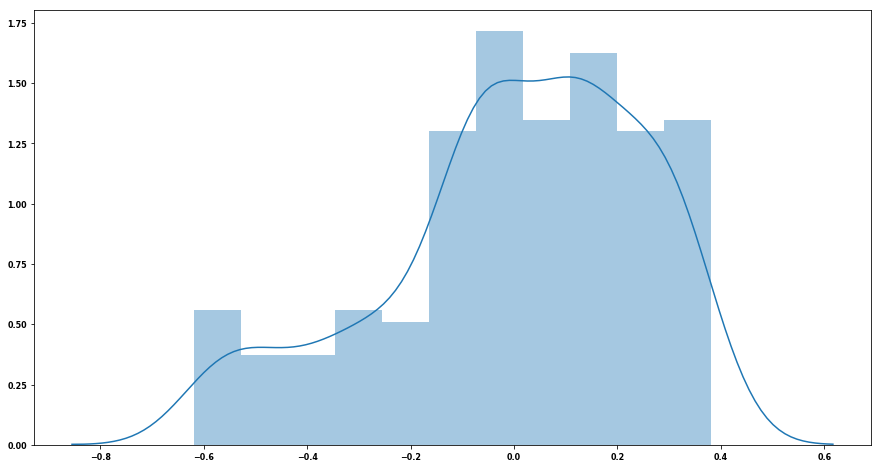

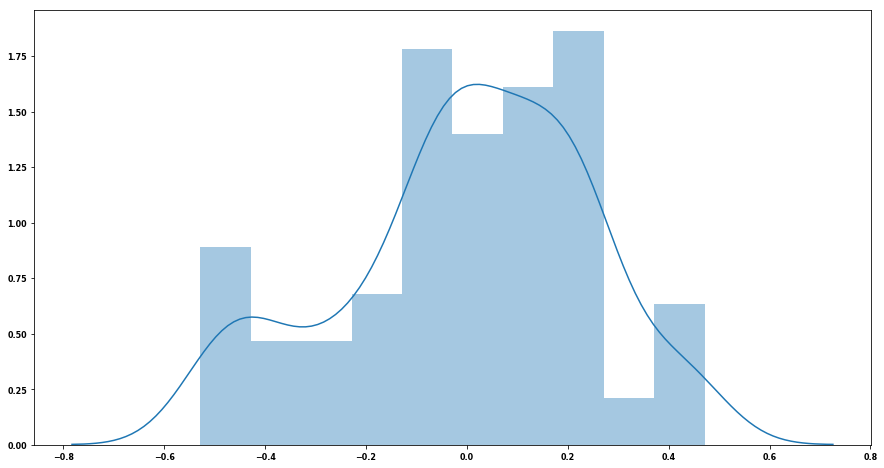

In [19]:
import seaborn as sns
color = sns.color_palette("hls", 11)

for zc in normalized_chi:
    fig = plt.figure(figsize=(15,8))
    sns.distplot(normalized_chi[zc])
    

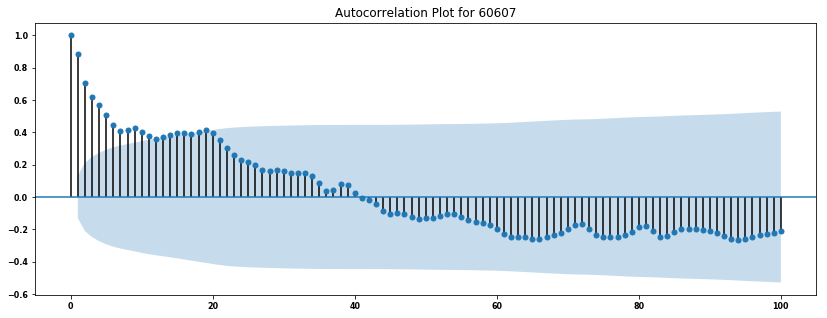

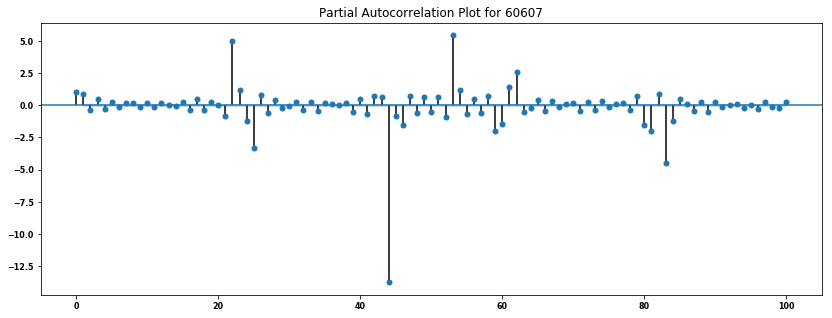

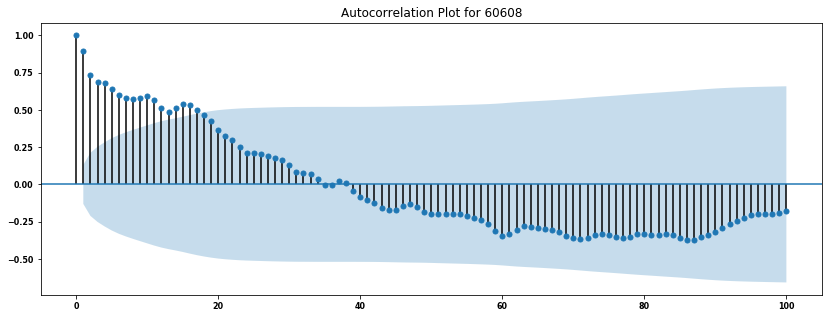

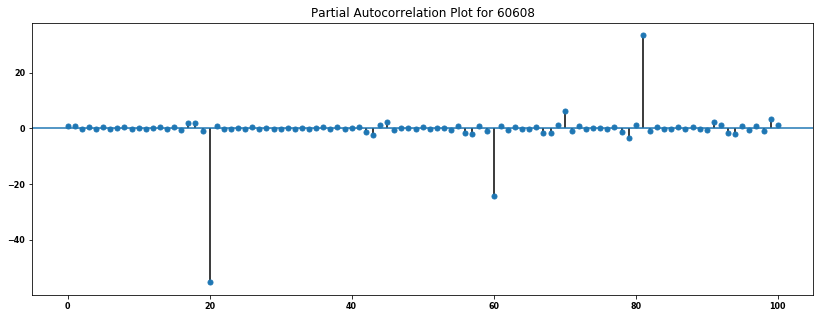

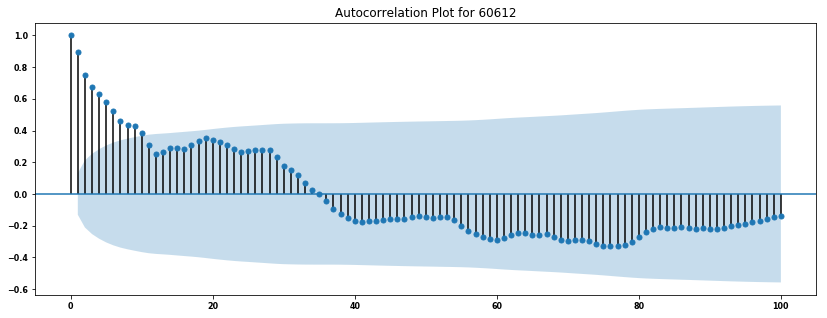

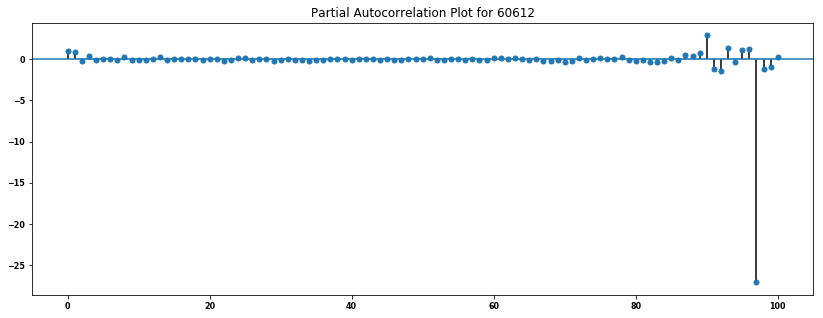

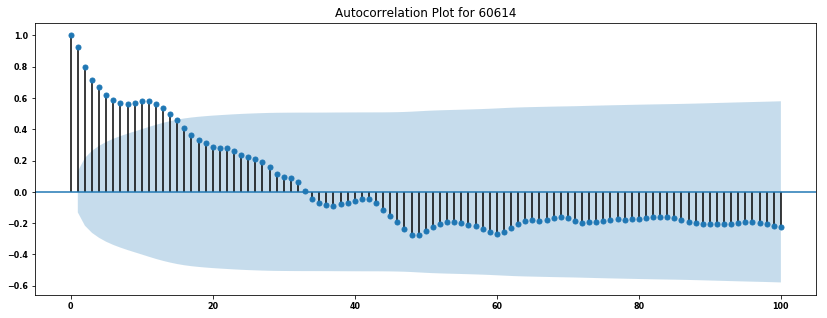

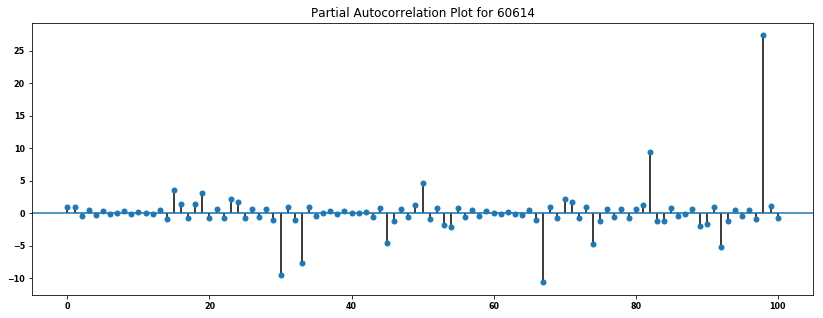

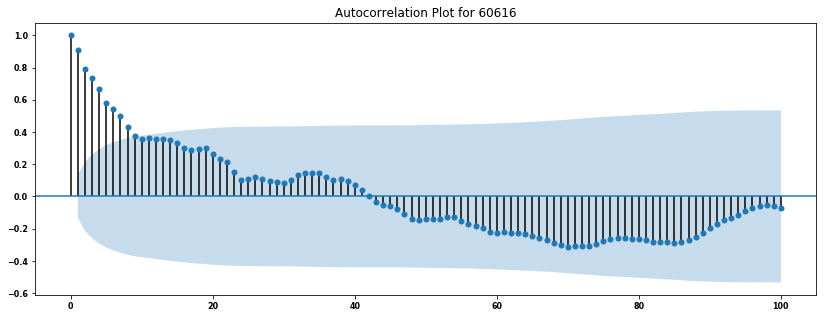

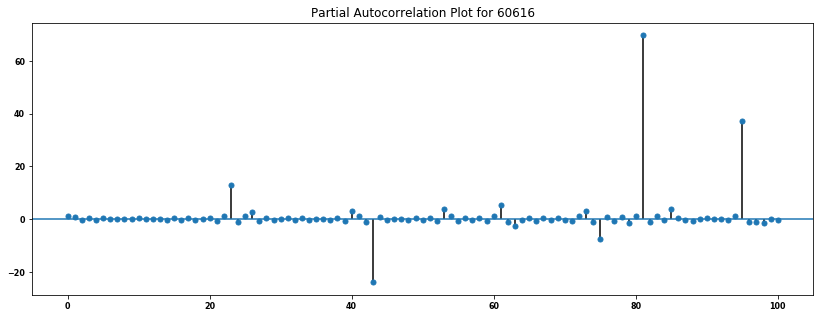

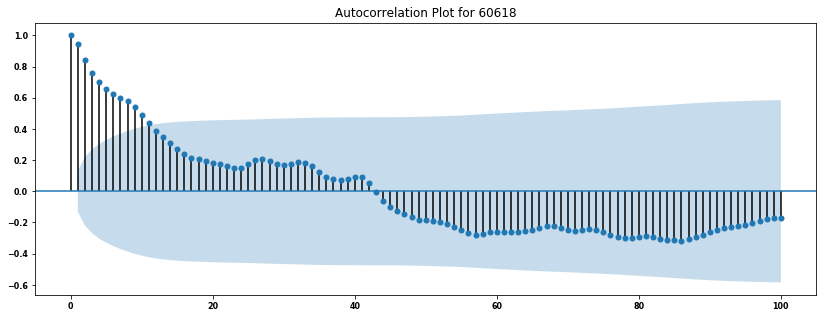

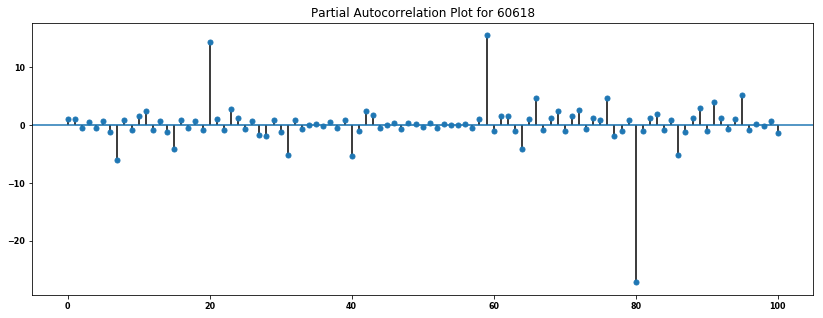

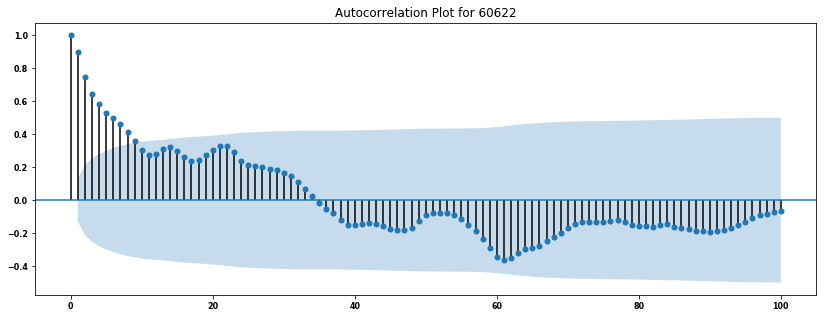

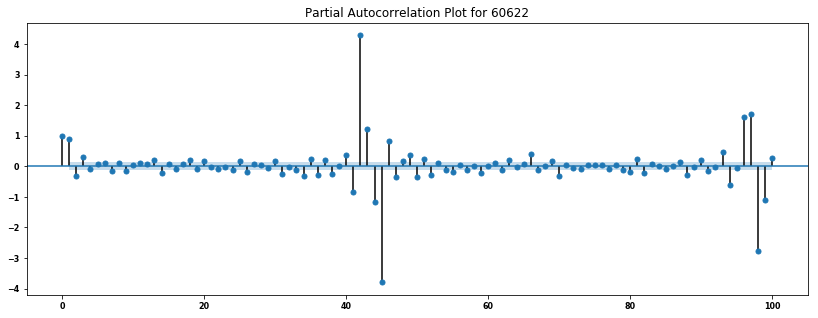

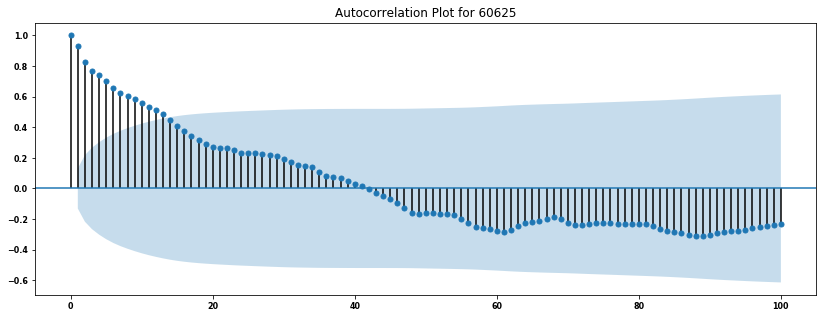

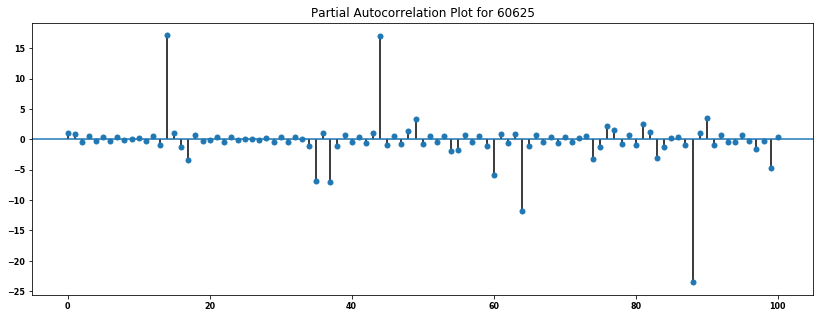

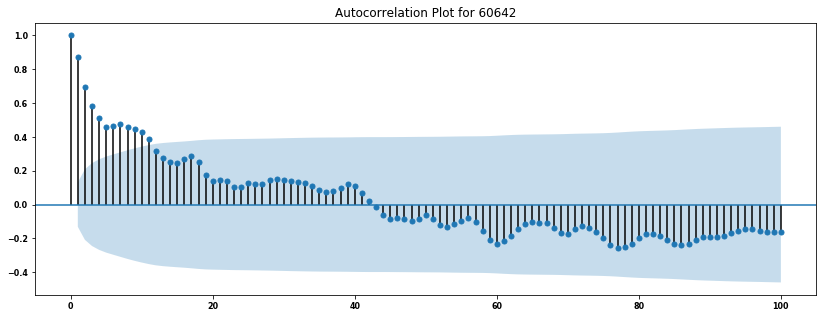

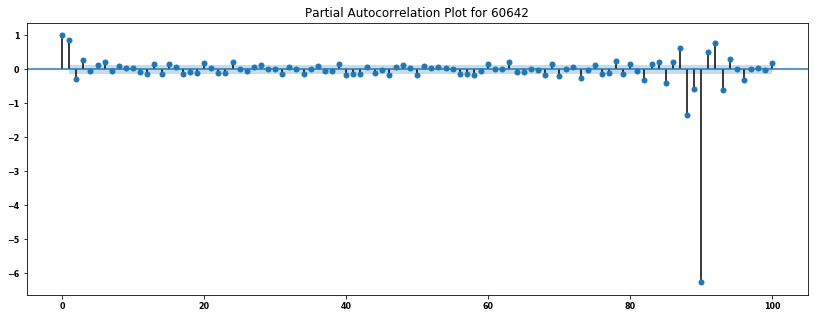

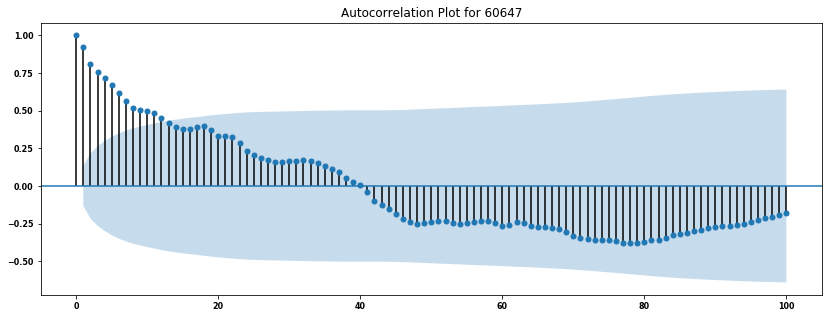

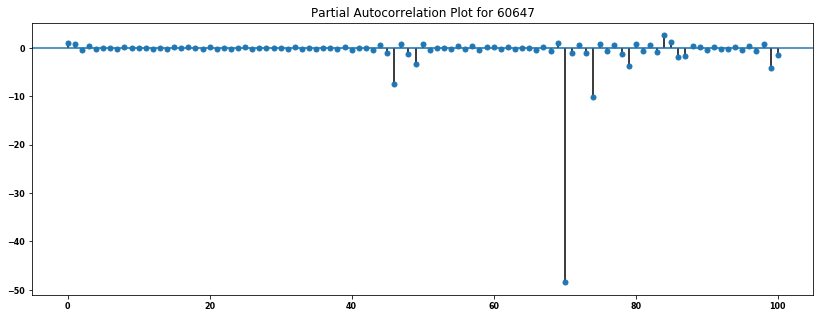

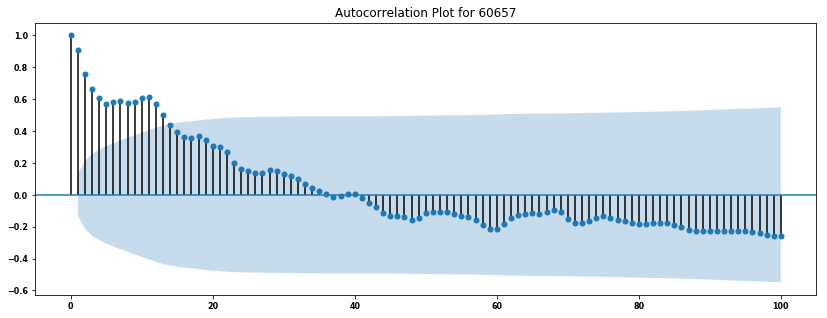

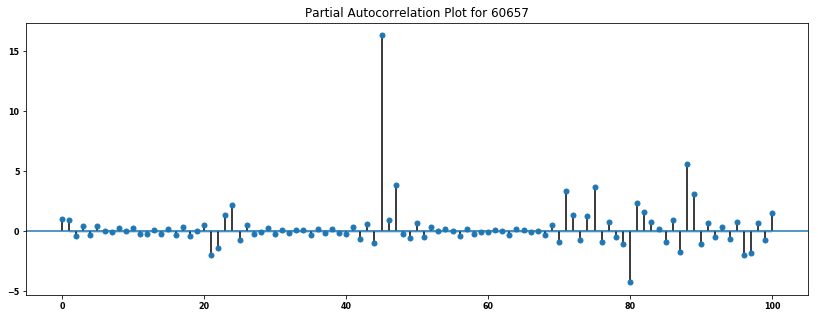

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams

zip_diff = zip_df.diff().dropna()
rcParams['figure.figsize'] = 14, 5
for col in zip_diff.columns:
    plot_acf(zip_diff[col], lags = 100)
    plt.title(f'Autocorrelation Plot for {col[0]}');
    plot_pacf(zip_diff[col], lags = 100)
    plt.title(f'Partial Autocorrelation Plot for {col[0]}');

# Step 5: ARIMA Modeling

In [21]:
import itertools 

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [22]:
import warnings
warnings.filterwarnings('ignore')
AIC = []
for zipcode in chi_dict.keys():
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(chi_dict[zipcode],
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False
                                                )
                results = mod.fit()
                AIC.append([zipcode, param, param_seasonal, np.abs(results.aic)])
            
            except:
                continue

In [23]:
AIC_df = pd.DataFrame(AIC, columns = ["zip","pdq", "pdqs", 'aic'])

In [24]:
AIC_dict = {}
for i, g in AIC_df.groupby('zip'):
    AIC_dict[i] = g
    

In [25]:
for zipcode in AIC_dict.keys():
    AIC_dict[zipcode].sort_values('aic', axis=0, inplace=True)
    AIC_dict[zipcode]=AIC_dict[zipcode].reset_index()
    AIC_dict[zipcode].drop(['index'], axis=1, inplace=True)
   # AIC_dict[zipcode].drop(['level_0'], axis=1, inplace=True)

In [29]:
for zipcode in AIC_dict.keys():
    print(AIC_dict[zipcode].iloc[0:3,:])

     zip        pdq           pdqs          aic
0  60608  (1, 1, 1)  (1, 1, 1, 12)  3765.759705
1  60608  (1, 1, 1)  (0, 1, 1, 12)  3787.925356
2  60608  (1, 1, 1)  (1, 1, 0, 12)  3847.875525
     zip        pdq           pdqs          aic
0  60612  (1, 1, 1)  (1, 1, 1, 12)  3938.423684
1  60612  (1, 1, 1)  (0, 1, 1, 12)  3953.862591
2  60612  (1, 1, 0)  (1, 1, 1, 12)  3964.661604
     zip        pdq           pdqs          aic
0  60616  (1, 1, 1)  (1, 1, 1, 12)  3619.327278
1  60616  (1, 1, 1)  (0, 1, 1, 12)  3642.488959
2  60616  (1, 1, 1)  (1, 1, 0, 12)  3676.994083
     zip        pdq           pdqs          aic
0  60618  (1, 1, 1)  (1, 1, 1, 12)  3506.199141
1  60618  (1, 1, 1)  (0, 1, 1, 12)  3514.483130
2  60618  (1, 1, 1)  (1, 1, 0, 12)  3557.644078
     zip        pdq           pdqs          aic
0  60625  (1, 1, 1)  (1, 1, 1, 12)  3495.929328
1  60625  (1, 1, 1)  (0, 1, 1, 12)  3508.751250
2  60625  (1, 1, 1)  (1, 1, 0, 12)  3548.017621
     zip        pdq           pdqs      

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  257
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1877.880
Date:                            Fri, 18 Oct 2019   AIC                           3765.760
Time:                                    17:51:28   BIC                           3782.950
Sample:                                         0   HQIC                          3772.694
                                            - 257                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7632      0.034     22.167      0.000       0.696       0.831
ma.L1          0.7762      0.028   

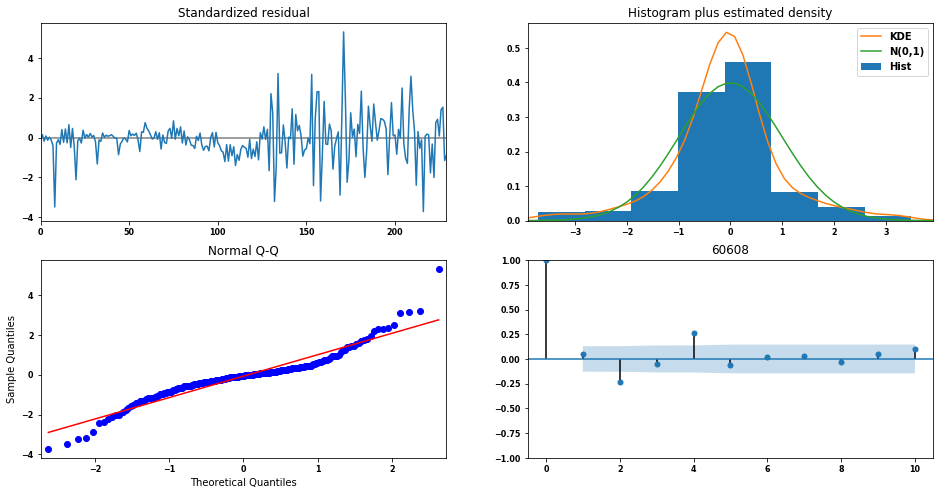

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  248
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1964.212
Date:                            Fri, 18 Oct 2019   AIC                           3938.424
Time:                                    17:51:29   BIC                           3955.414
Sample:                                09-01-1997   HQIC                          3945.284
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7738      0.064     12.114      0.000       0.649       0.899
ma.L1          0.3151      0.044   

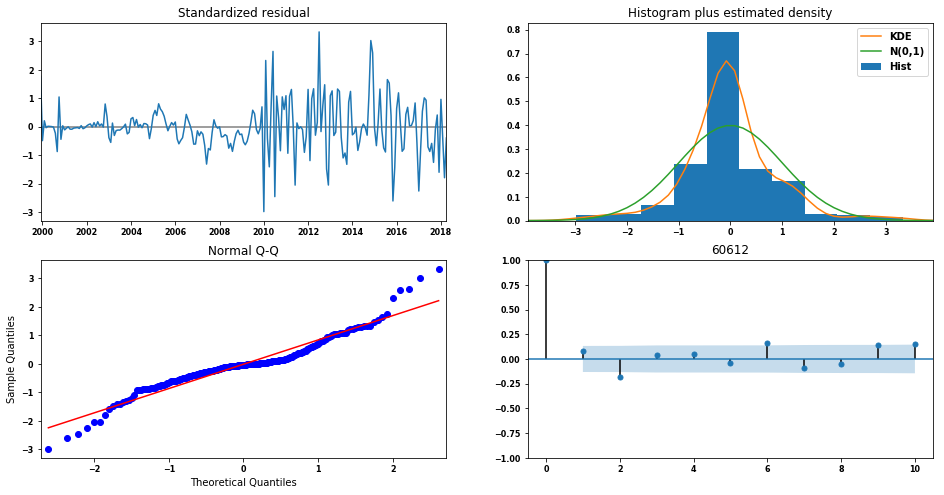

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  242
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1804.664
Date:                            Fri, 18 Oct 2019   AIC                           3619.327
Time:                                    17:51:32   BIC                           3636.180
Sample:                                03-01-1998   HQIC                          3626.137
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7642      0.035     22.093      0.000       0.696       0.832
ma.L1          0.5807      0.040   

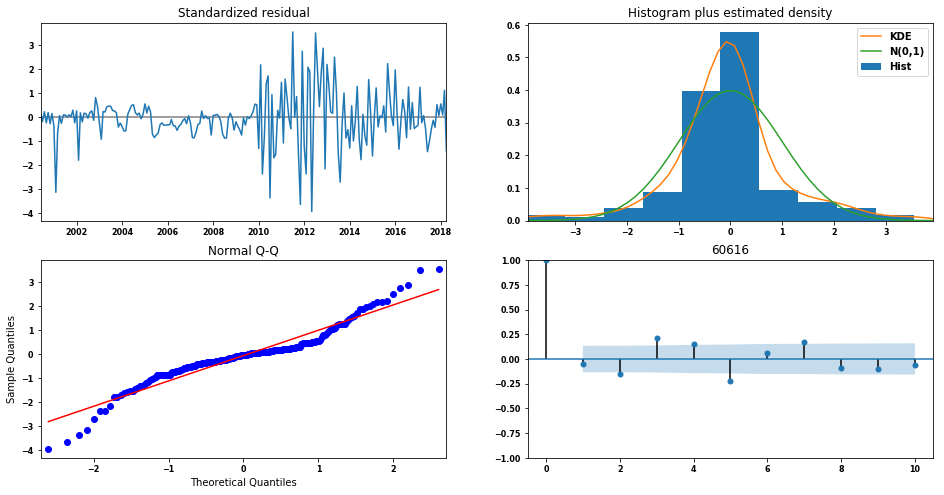

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  239
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1748.100
Date:                            Fri, 18 Oct 2019   AIC                           3506.199
Time:                                    17:51:34   BIC                           3522.982
Sample:                                06-01-1998   HQIC                          3512.982
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8652      0.040     21.686      0.000       0.787       0.943
ma.L1          0.7544      0.040   

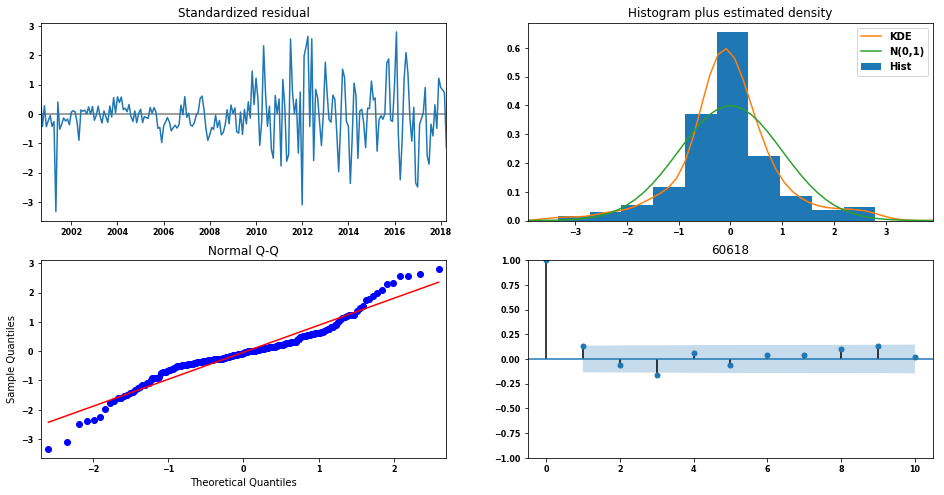

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  237
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1742.965
Date:                            Fri, 18 Oct 2019   AIC                           3495.929
Time:                                    17:51:36   BIC                           3512.665
Sample:                                08-01-1998   HQIC                          3502.695
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8005      0.037     21.563      0.000       0.728       0.873
ma.L1          0.7302      0.034   

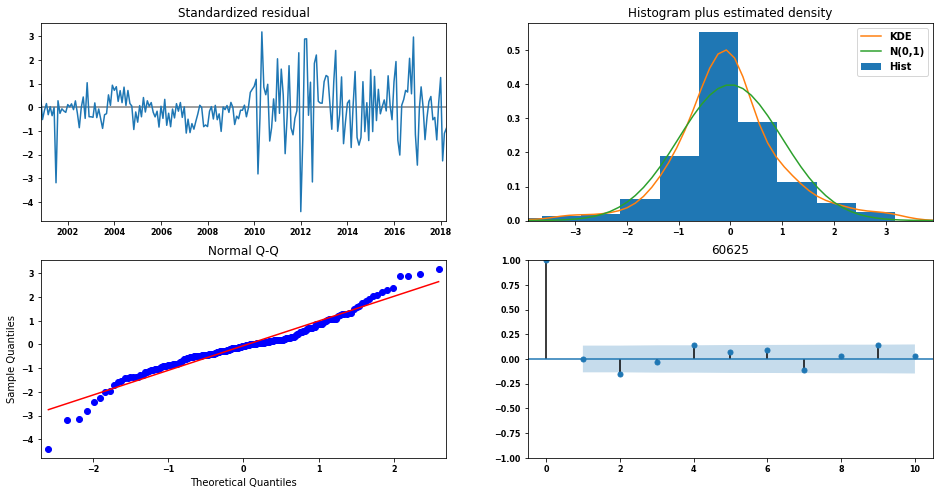

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  236
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1768.227
Date:                            Fri, 18 Oct 2019   AIC                           3546.453
Time:                                    17:51:39   BIC                           3563.165
Sample:                                01-01-1998   HQIC                          3553.210
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7953      0.038     21.104      0.000       0.721       0.869
ma.L1          0.5466      0.043   

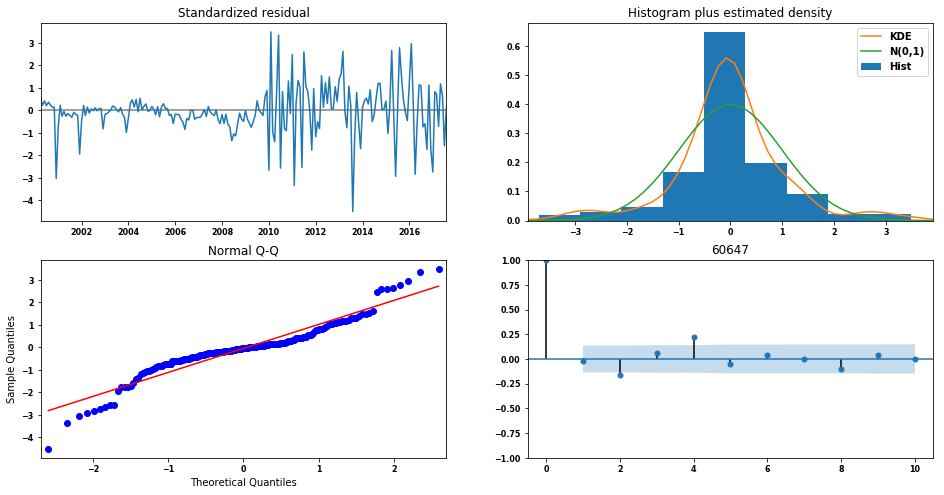

In [27]:
for zipcode in AIC_dict.keys():
    pdq = AIC_dict[zipcode].loc[AIC_dict[zipcode]['aic'].idxmin()]['pdq']
    pdqs = AIC_dict[zipcode].loc[AIC_dict[zipcode]['aic'].idxmin()]['pdqs']
    
    mod = sm.tsa.statespace.SARIMAX(chi_dict[zipcode],
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary())
    results.plot_diagnostics(figsize=(16, 8))
    plt.title(zipcode)
    plt.show();

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  257
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1889.963
Date:                            Fri, 18 Oct 2019   AIC                           3787.925
Time:                                    17:56:44   BIC                           3801.678
Sample:                                         0   HQIC                          3793.473
                                            - 257                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7082      0.034     20.575      0.000       0.641       0.776
ma.L1          0.7646      0.030   

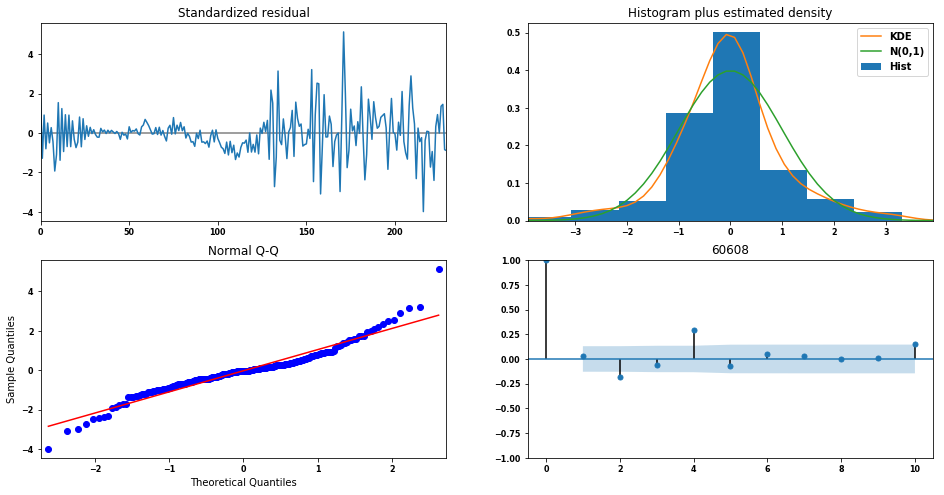

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  248
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1972.931
Date:                            Fri, 18 Oct 2019   AIC                           3953.863
Time:                                    17:56:45   BIC                           3967.455
Sample:                                09-01-1997   HQIC                          3959.351
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7177      0.062     11.663      0.000       0.597       0.838
ma.L1          0.4861      0.056   

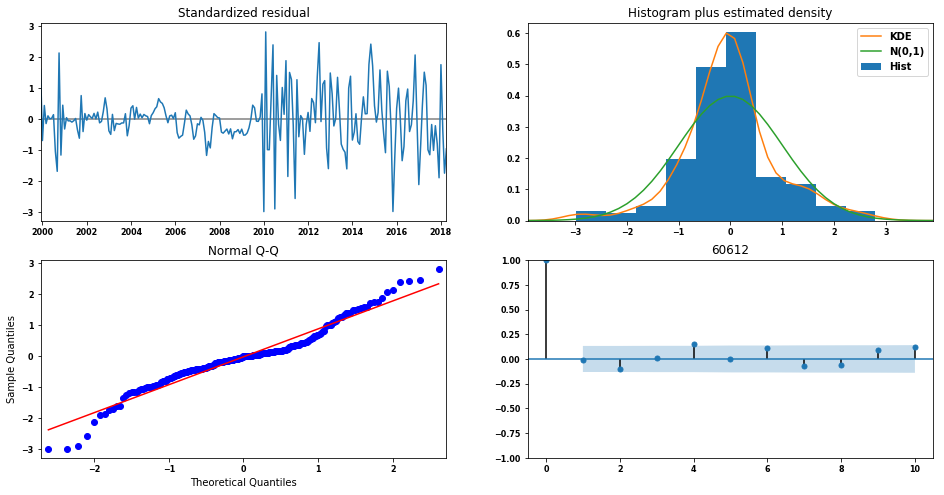

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  242
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1817.244
Date:                            Fri, 18 Oct 2019   AIC                           3642.489
Time:                                    17:56:47   BIC                           3655.972
Sample:                                03-01-1998   HQIC                          3647.937
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7436      0.042     17.836      0.000       0.662       0.825
ma.L1          0.5304      0.047   

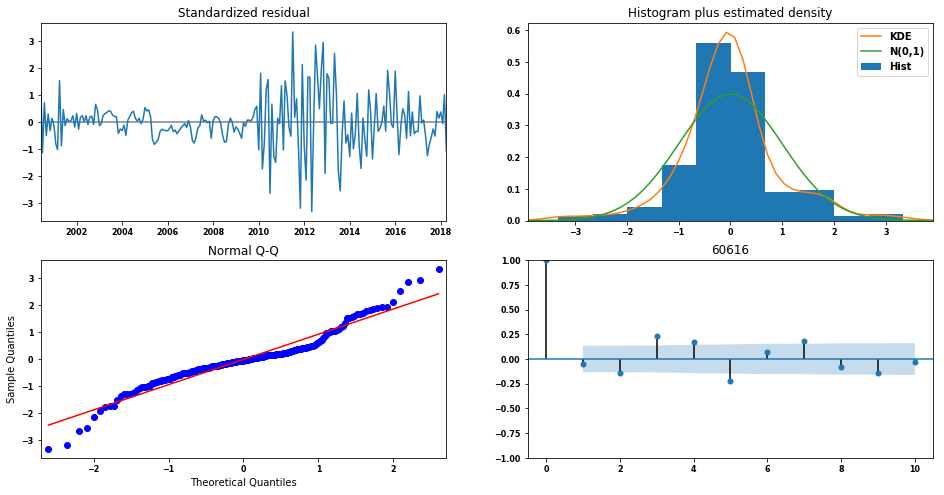

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  239
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1753.242
Date:                            Fri, 18 Oct 2019   AIC                           3514.483
Time:                                    17:56:49   BIC                           3527.909
Sample:                                06-01-1998   HQIC                          3519.910
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8602      0.030     28.663      0.000       0.801       0.919
ma.L1          0.7339      0.030   

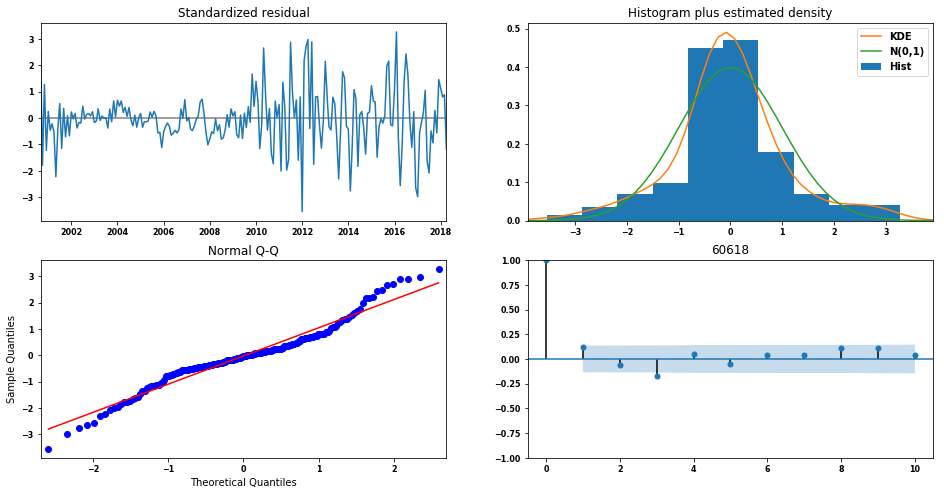

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  237
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1750.376
Date:                            Fri, 18 Oct 2019   AIC                           3508.751
Time:                                    17:56:51   BIC                           3522.140
Sample:                                08-01-1998   HQIC                          3514.164
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7814      0.037     21.270      0.000       0.709       0.853
ma.L1          0.7052      0.033   

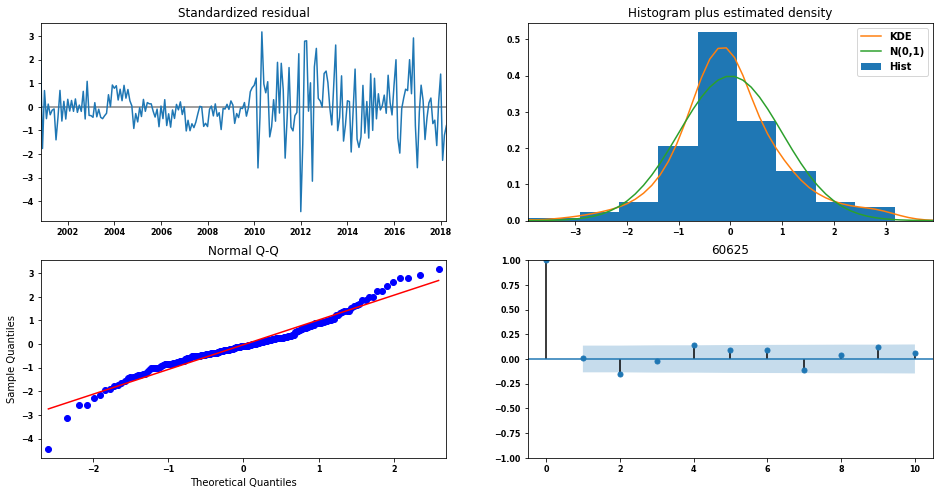

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  236
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1775.159
Date:                            Fri, 18 Oct 2019   AIC                           3558.317
Time:                                    17:56:53   BIC                           3571.686
Sample:                                01-01-1998   HQIC                          3563.722
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7708      0.038     20.387      0.000       0.697       0.845
ma.L1          0.5347      0.040   

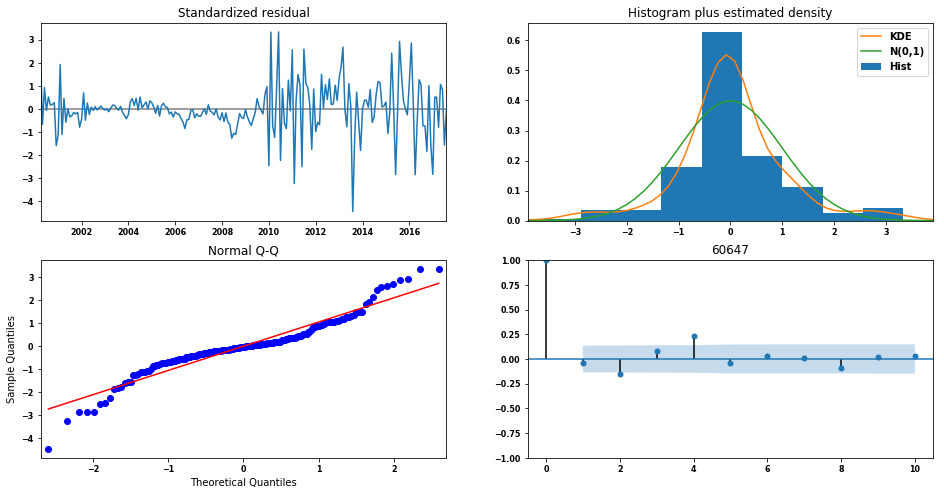

In [36]:
for zipcode in AIC_dict.keys():
    pdq = AIC_dict[zipcode].iloc[1,:]['pdq']
    pdqs = AIC_dict[zipcode].iloc[1,:]['pdqs']
    
    mod = sm.tsa.statespace.SARIMAX(chi_dict[zipcode],
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary())
    results.plot_diagnostics(figsize=(16, 8))
    plt.title(zipcode)
    plt.show();

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  257
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood               -1919.938
Date:                            Fri, 18 Oct 2019   AIC                           3847.876
Time:                                    17:57:18   BIC                           3861.645
Sample:                                         0   HQIC                          3853.429
                                            - 257                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6572      0.040     16.495      0.000       0.579       0.735
ma.L1          0.7482      0.032   

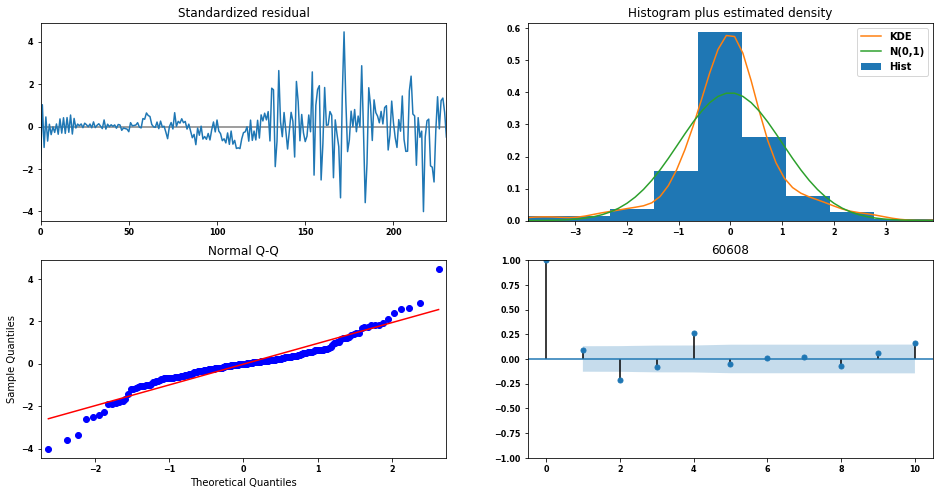

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  248
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -1978.331
Date:                            Fri, 18 Oct 2019   AIC                           3964.662
Time:                                    17:57:20   BIC                           3978.272
Sample:                                09-01-1997   HQIC                          3970.157
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8544      0.034     25.351      0.000       0.788       0.920
ar.S.L12      -0.5836      0.056   

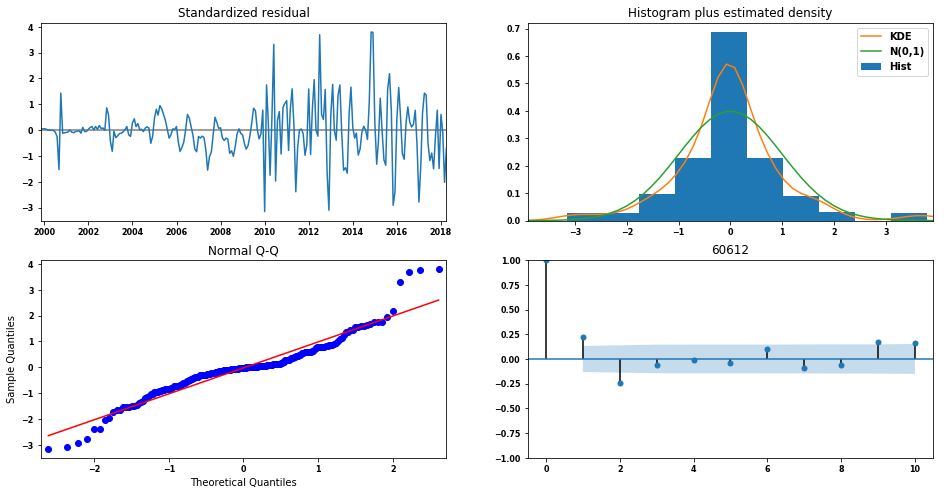

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  242
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood               -1834.497
Date:                            Fri, 18 Oct 2019   AIC                           3676.994
Time:                                    17:57:22   BIC                           3690.495
Sample:                                03-01-1998   HQIC                          3682.449
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7349      0.035     20.835      0.000       0.666       0.804
ma.L1          0.5487      0.044   

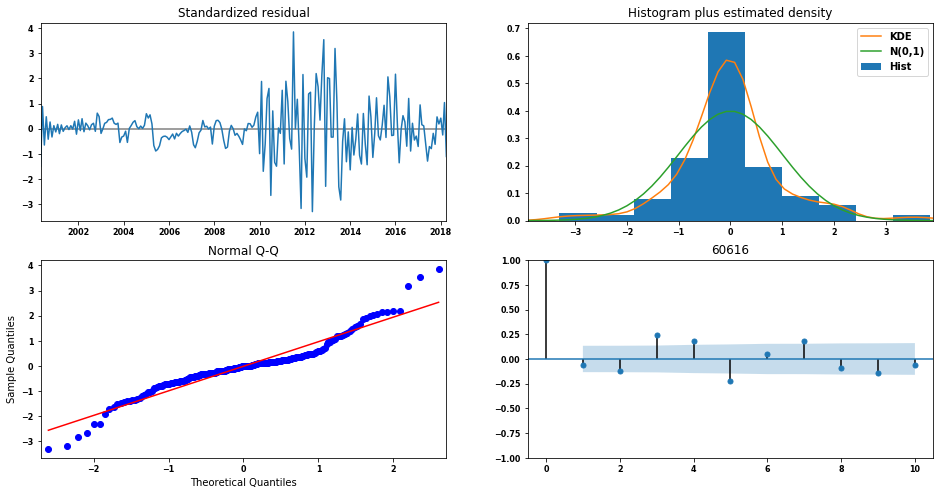

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  239
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood               -1774.822
Date:                            Fri, 18 Oct 2019   AIC                           3557.644
Time:                                    17:57:24   BIC                           3571.089
Sample:                                06-01-1998   HQIC                          3563.078
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8489      0.032     26.766      0.000       0.787       0.911
ma.L1          0.7407      0.034   

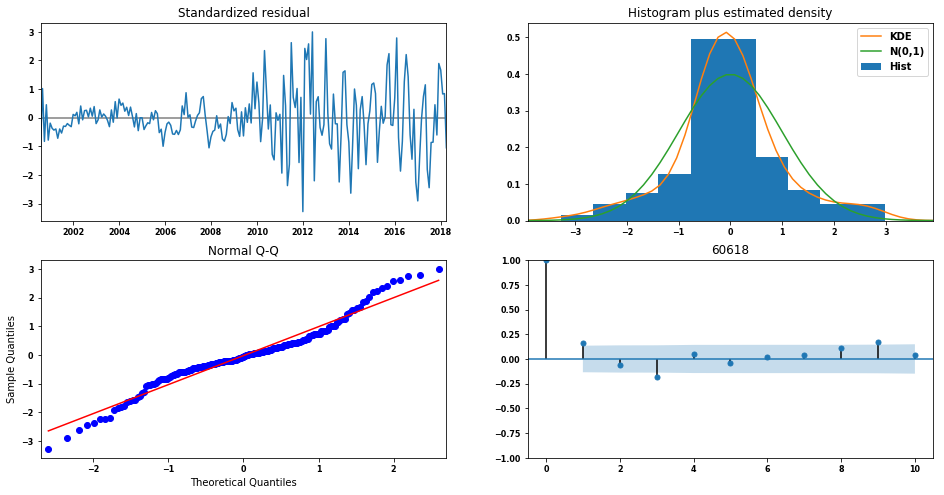

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  237
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood               -1770.009
Date:                            Fri, 18 Oct 2019   AIC                           3548.018
Time:                                    17:57:26   BIC                           3561.425
Sample:                                08-01-1998   HQIC                          3553.437
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7613      0.043     17.596      0.000       0.677       0.846
ma.L1          0.7186      0.038   

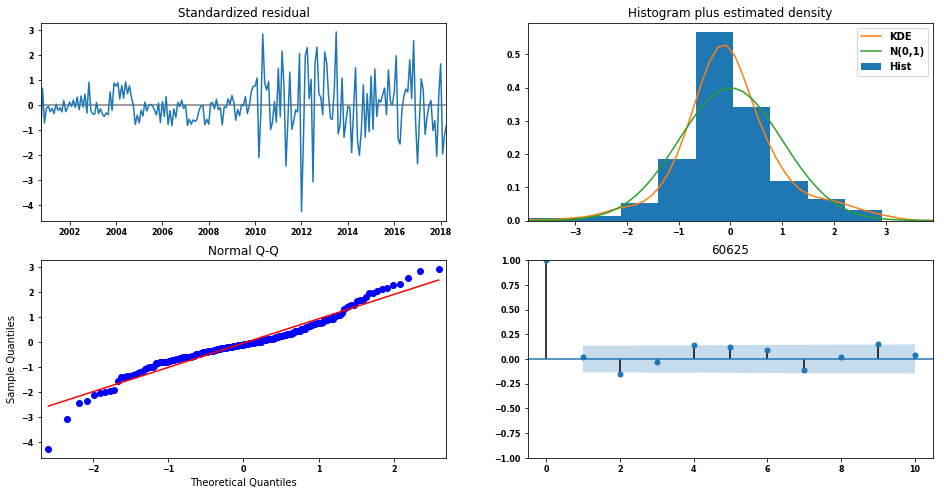

                                 Statespace Model Results                                 
Dep. Variable:                              value   No. Observations:                  236
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood               -1796.472
Date:                            Fri, 18 Oct 2019   AIC                           3600.943
Time:                                    17:57:28   BIC                           3614.332
Sample:                                01-01-1998   HQIC                          3606.356
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7771      0.043     17.913      0.000       0.692       0.862
ma.L1          0.4293      0.052   

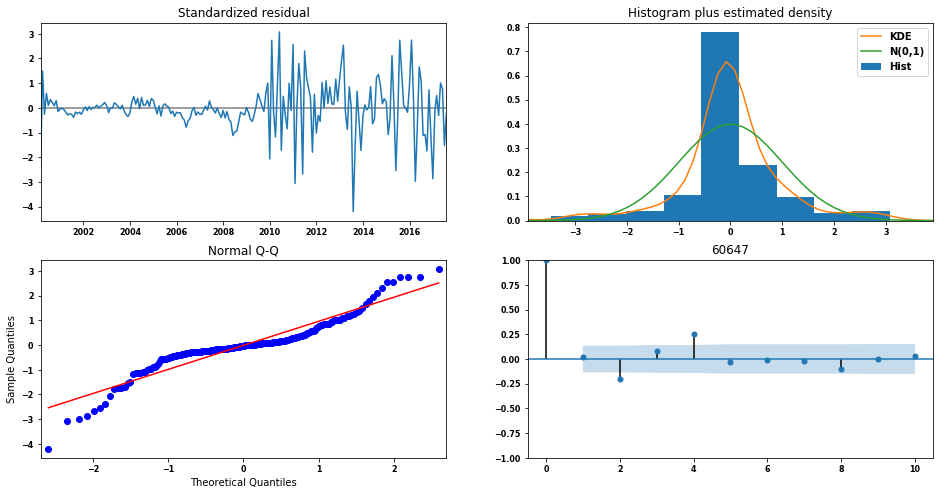

In [37]:
for zipcode in AIC_dict.keys():
    pdq = AIC_dict[zipcode].iloc[2,:]['pdq']
    pdqs = AIC_dict[zipcode].iloc[2,:]['pdqs']
    
    mod = sm.tsa.statespace.SARIMAX(chi_dict[zipcode],
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary())
    results.plot_diagnostics(figsize=(16, 8))
    plt.title(zipcode)
    plt.show();

In [42]:
for zipcode in AIC_dict.keys():
    pdq = AIC_dict[zipcode].loc[AIC_dict[zipcode]['aic'].idxmin()]['pdq']
    pdqs = AIC_dict[zipcode].loc[AIC_dict[zipcode]['aic'].idxmin()]['pdqs']
    
    mod = sm.tsa.statespace.SARIMAX(chi_dict[zipcode]['2008':],
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    results.predict(start='04-01-2018', end='12-31-2022')
    print(results.summary())
    results.plot_diagnostics(figsize=(16, 8))
    plt.title(zipcode)
    plt.show();

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'

# Step 6: Interpreting Results